✍ Настало время попрактиковаться применять модель линейной регрессии и её модификации в задачах регрессии.

В этот раз мы коснёмся мира медицинского страхования. Нашей целью будет предсказать индивидуальные медицинские расходы граждан США, оплачиваемые медицинской страховкой.

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import plotly.express as px

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [2]:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:

age — возраст основного бенефициара;

sex — пол страхового подрядчика;

bmi — индекс массы тела ($кг/м^{2}$), в идеале — от 18.5 до 24.9;

children — количество детей, охваченных медицинской страховкой;

smoker — является ли человек курящим;

region — жилой район США (северо-восток, юго-восток, северо-запад, юго-запад);

charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

In [3]:
print(data.shape)

(1338, 7)


In [4]:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски в таблице отсутствуют.

Посмотрим на типы данных:

In [5]:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Наши данные содержат несколько типов признаков:

age, bmi, children — числовые признаки;

sex, smoker — бинарные категориальные переменные (две категории);

region — множественные категориальные переменные (несколько категорий);

charges — числовой целевой признак.

Прежде чем приступать к этапу подготовки данных для модели, мы решили произвести небольшое исследование зависимостей в данных, например построить следующие графики и диаграммы:

гистограммы/коробчатые диаграммы числовых признаков;

столбчатые диаграммы медианных медицинских расходов в зависимости от категориальных признаков;

диаграммы рассеяния зависимости целевого признака от других числовых в разрезе категориальных (обратите особенное внимание на зависимость медицинских расходов от признака курения).

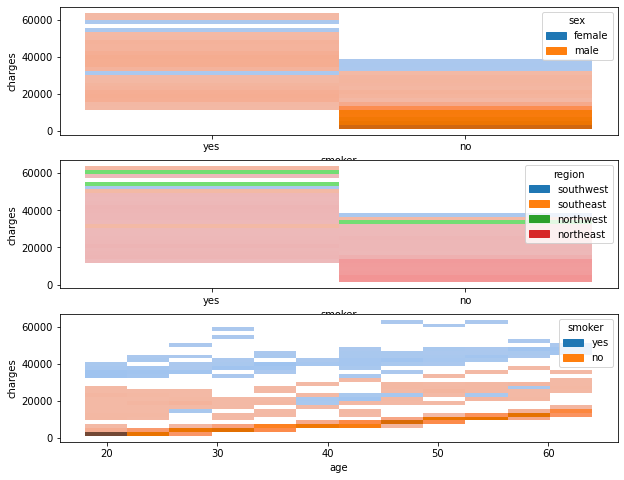

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
sns.histplot(data=data,
             x='smoker',
             y='charges',
             hue='sex',
             ax=axes[0]);
sns.histplot(data=data,
             x='smoker',
             y='charges',
             hue='region',
             ax=axes[1]);
sns.histplot(data=data,
             x='age',
             y='charges',
             hue='smoker',
             ax=axes[2]);

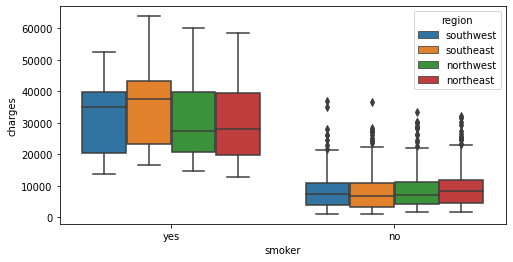

In [7]:
fig = plt.figure(figsize=(8,4))
axes = sns.boxplot(data=data,
               x='smoker',
               y='charges',
               hue='region',)#,
            #    x='smoker',
            #    ag)

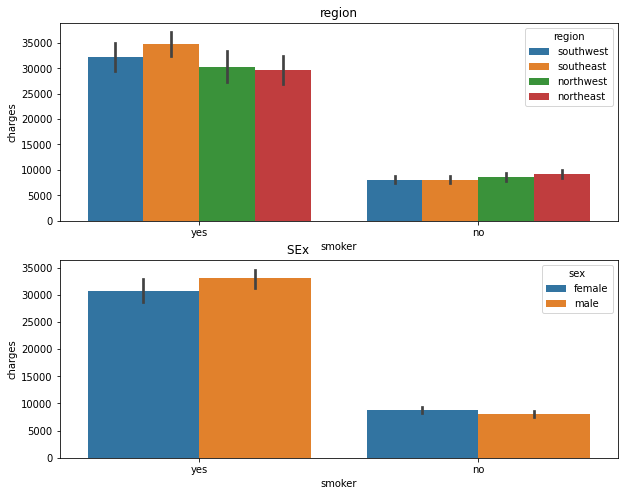

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
axes[0].set_title('region')
sns.barplot(data=data,
    x='smoker',
    y='charges',
    hue='region',
    ax=axes[0]);
axes[1].set_title('SEx                     ')
sns.barplot(data=data,
    x='smoker',
    y='charges',
    hue='sex',
    ax=axes[1]);

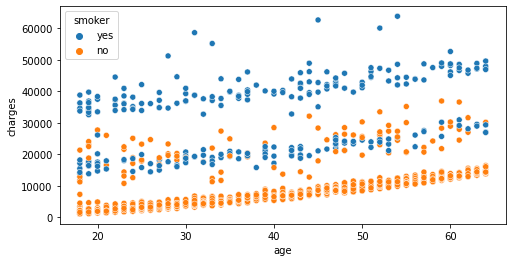

In [9]:
fig = plt.figure(figsize=(8,4))
axes = sns.scatterplot(data=data,
                       x='age',
                       y='charges',
                       hue='smoker')


### Практика графики

In [4]:
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

<AxesSubplot:xlabel='age', ylabel='charges'>

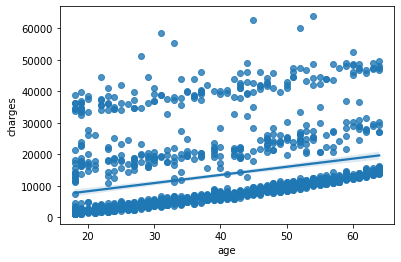

In [7]:
sns.regplot(data=data, x='age', y='charges')

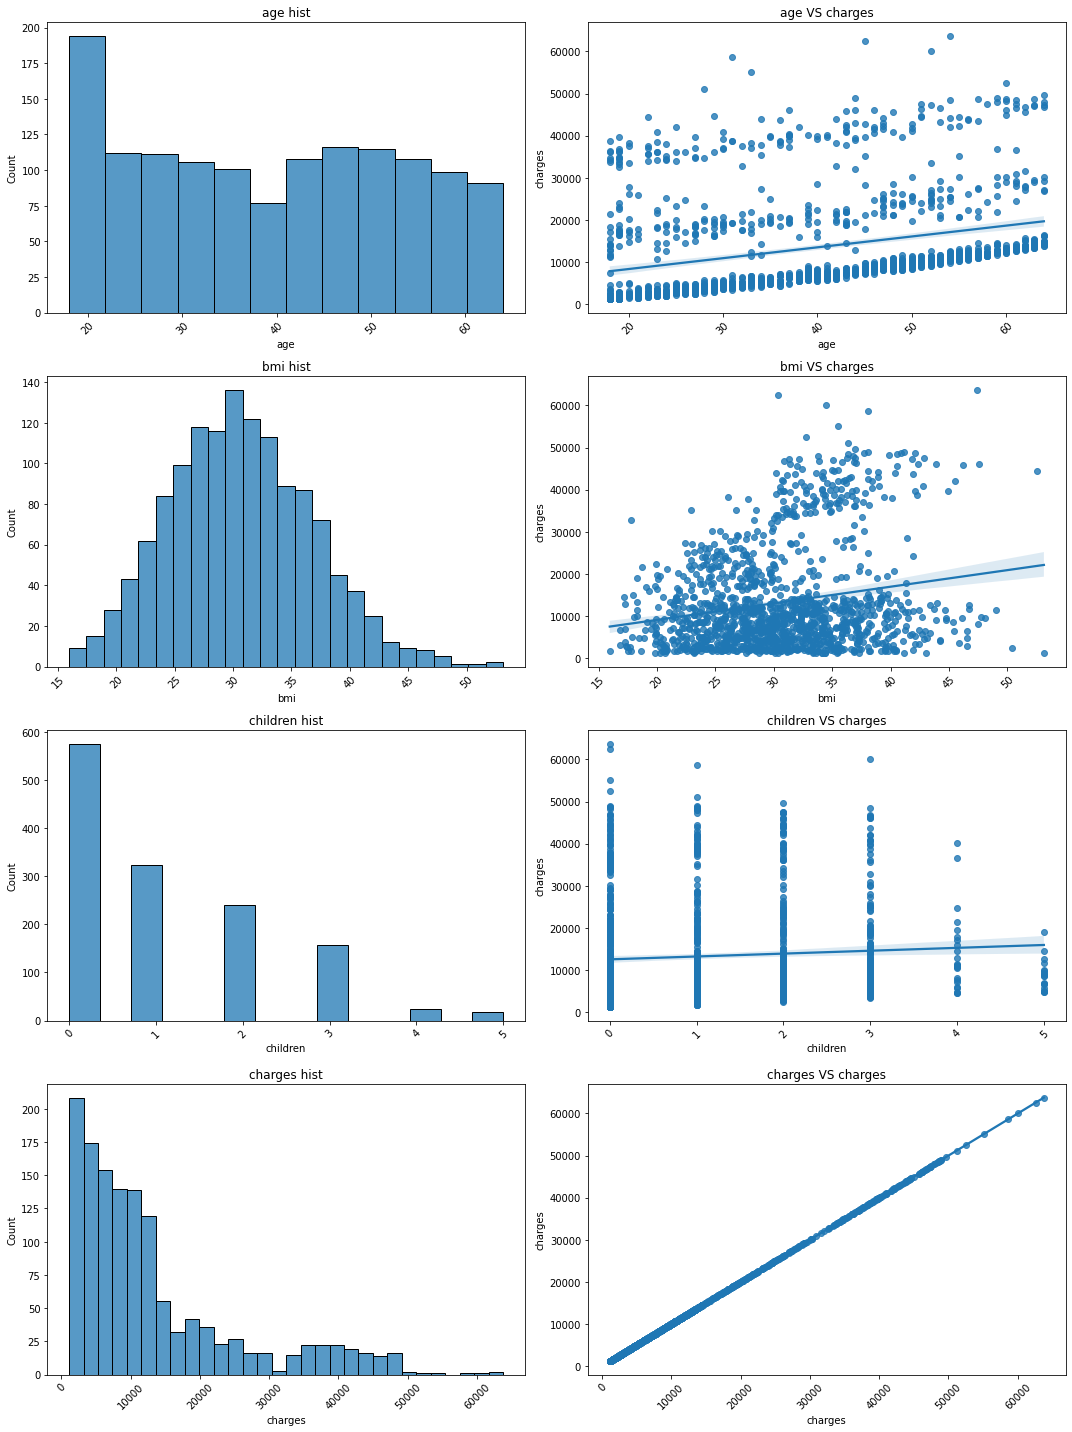

In [6]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='charges', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS charges'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

Мы знаем, что модель линейной регрессии не умеет работать с категориальными признаками, поэтому категории необходимо перекодировать.

Кодировку будем совершать по следующему принципу:

smoker — переведём в бинарные значения (0 — некурящий, 1 — курящий);
sex — аналогично (0 — female, 1 — male);
region — используем OneHot-кодирование (воспользуемся функцией get_dummies).

In [10]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


Выделим факторы и целевой признак в отдельные таблицы:

In [11]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

### Задание 6.1
Прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.

Разделите набор данных на тренировочную и тестовую выборки в соотношении 80/20. Воспользуйтесь функцией train_test_split.

В качестве значения параметра random_state укажите число 42.

Чему равно количество наблюдений в тестовом наборе данных?

In [12]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_test.shape

(268, 9)

Задание 6.2
Обучите модель линейной регрессии аналитическим методом (LinearRegression) на тренировочном наборе данных. Все параметры оставьте по умолчанию.

Чему равен свободный член (intercept) обученной модели? Ответ округлите до сотых.

In [14]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)


LinearRegression()

In [15]:
round(lr.intercept_, 2)

-12390.8

Задание 6.3
С помощью модели, полученной в предыдущем задании, сделайте предсказание на тренировочной и тестовой выборке. Рассчитайте следующие три метрики:$R^{2}$ ,$MAE$ ,$MAPE$ . Не забудьте привести значение  к процентам.

Значение $R^{2}$ округлите до трёх знаков после точки-разделителя, а значения $MAE$ и $MAPE$ — до целого числа.

Чему равны значения метрик на тренировочной и тестовой выборках?

In [16]:
#Функция для вывода

def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.0f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.0f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))
    
    #Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208
Train MAPE: 42


Test R^2: 0.784
Test MAE: 4181
Train MAPE: 47


Задание 6.4

Постройте диаграмму boxplot для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках. В качестве ошибки возьмите разницу между истинным ответом и предсказанием: $y-\hat{y}$ (без модуля).



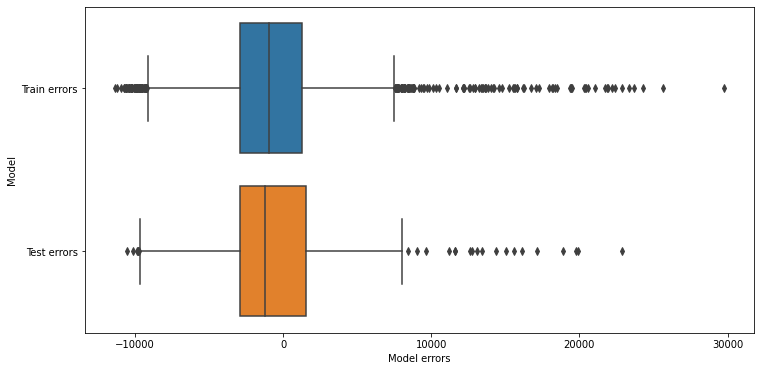

In [17]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - lr.predict(X_train)
#Ошибки модели на тестовой выборке
y_test_errors = y_test - lr.predict(X_test)
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

Задание 6.5

Нормализуйте тренировочную и тестовую выборки с помощью min-max-нормализации (MinMaxScaler). Расчёт параметров нормализации (fit) произведите на тренировочной выборке.

Примечание. Min-max-нормализация не искажает изначальный вид бинарных категориальных признаков, в отличие от стандартизации.

На нормализованных данных сгенерируйте полиномиальные признаки степени 2. Воспользуйтесь классом PolynomialFeatures из библиотеки sklearn. Значение параметра include_bias выставите на False.

Чему равно результирующее количество столбцов?

In [18]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)
print(X_train_scaled_poly.shape)

(1070, 54)


In [20]:
X_train_scaled_poly

array([[0.60869565, 0.        , 0.10734463, ..., 0.        , 0.        ,
        0.        ],
       [0.63043478, 0.        , 0.22491256, ..., 0.        , 0.        ,
        0.        ],
       [0.73913043, 0.        , 0.23944041, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.86956522, 1.        , 0.24791499, ..., 0.        , 0.        ,
        0.        ],
       [0.41304348, 0.        , 0.85122411, ..., 0.        , 0.        ,
        1.        ],
       [0.80434783, 1.        , 0.37503363, ..., 0.        , 0.        ,
        1.        ]])

Задание 6.6

Обучите модель линейной регрессии на полиномиальных признаках.

Чему равно значение метрики R^{2} на тестовой выборке?

Значение R^{2} округлите до трёх знаков после запятой.

In [25]:
#Инициализируем объект класса линейная регрессия
lr_poly = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = lr_poly.predict(X_train_scaled_poly)
y_test_predict = lr_poly.predict(X_test_scaled_poly)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.842
Train MAE: 2919
Train MAPE: 30


Test R^2: 0.866
Test MAE: 2758
Train MAPE: 31


Задание 6.7


Выведите значения коэффициентов полученной модели. Посмотрите на степени коэффициентов.

Какой вывод можно сделать?

**Значения коэффициентов очень высокие, модель неустойчива, необходима регуляризация.**

In [26]:
print(lr_poly.coef_)

[-5.10204014e+16  1.88937228e+17 -1.56699918e+15 -1.11998824e+16
  5.46963534e+15  1.26284008e+16  5.75481713e+15  1.62667956e+16
  2.32533979e+15  8.48000000e+03  8.88000000e+02  1.06800000e+03
 -1.67200000e+03  1.88000000e+02  5.10204014e+16  5.10204014e+16
  5.10204014e+16  5.10204014e+16 -1.81533526e+17  6.96000000e+02
 -1.22275000e+03  3.09250000e+02 -7.40370256e+15 -7.40370256e+15
 -7.40370256e+15 -7.40370256e+15 -9.56562500e+03  1.64193750e+03
  5.48491562e+04  1.56699918e+15  1.56699918e+15  1.56699918e+15
  1.56699918e+15 -1.98400000e+03 -2.25600000e+03  1.11998824e+16
  1.11998824e+16  1.11998824e+16  1.11998824e+16  5.39493638e+15
 -1.08645717e+16 -1.08645717e+16 -1.08645717e+16 -1.08645717e+16
  4.21715577e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.10907395e+16  0.00000000e+00  0.00000000e+00  5.78761046e+14
  0.00000000e+00  1.45202168e+16]


Задание 6.8

Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000.

Чему равны метрики ,  и  на тестовой выборке?

Значение  округлите до трёх знаков после запятой, а значения  и  до целого числа.

In [29]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter=2000)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.842
Train MAE: 2890
Train MAPE: 29


Test R^2: 0.867
Test MAE: 2719
Train MAPE: 30


Задание 6.9

Постройте линейную регрессию с L2-регуляризацией на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию.

Чему равны метрики ,  и  на тестовой выборке?

Значение  округлите до трёх знаков после запятой, а значения  и  до целого числа.

In [31]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)
 

# Train R^2: 0.907
# Test R^2: 0.831

Train R^2: 0.839
Train MAE: 2949
Train MAPE: 30


Test R^2: 0.863
Test MAE: 2861
Train MAPE: 31


ДОПОЛНИТЕЛЬНО:

[Десять датасетов для практики работы с линейной регрессией](https://www.telusinternational.com/articles/10-open-datasets-for-linear-regression)

[Базовые принципы машинного обучения на примере линейной регрессии](https://habr.com/ru/company/ods/blog/322076/)

[Регрессионные модели в Python](https://nagornyy.me/it/regressionnye-modeli-v-python/)